In [21]:
#libraries used
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import streamlit as st

In [23]:
# Download a List of 30 cryptocurrencies
crypto_symbols = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'BCH-USD', 'ADA-USD', 'DOT-USD',
    'BNB-USD', 'LINK-USD', 'XLM-USD', 'DOGE-USD', 'UNI-USD', 'AAVE-USD', 'ATOM-USD',
    'AVAX-USD', 'MATIC-USD', 'SOL-USD', 'CHR-USD', 'ALGO-USD', 'FTT-USD', 'VET-USD',
    'FIL-USD', 'TRX-USD', 'ETC-USD', 'XMR-USD', 'EOS-USD', 'THETA-USD', 'NEO-USD',
    'DASH-USD', 'ZEC-USD'
]

end_date = datetime.today()
start_date = end_date - timedelta(days=365)  
all_data = pd.DataFrame()
# Loop through each cryptocurrency to download its data
for symbol in crypto_symbols:
    print(f"Downloading data for {symbol}...")
    crypto_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
    # Add a column for the cryptocurrency symbol
    crypto_data['Symbol'] = symbol
    # Append the data to the all_data DataFrame
    all_data = pd.concat([all_data, crypto_data])

# Reset the index to make it a "normal" DataFrame with default integer indexing
all_data.reset_index(inplace=True)

# Pivot the data by ticker symbol, using "Date" as the index
pivot_data = all_data.pivot_table(index='Date', columns='Symbol', values=['Open', 'High', 'Low', 'Close', 'Volume'])

# Flatten the multi-level columns
pivot_data.columns = [f"{val[1]}_{val[0]}" for val in pivot_data.columns]

# Save the pivoted data to a CSV file
pivot_data.to_csv('cryptocurrency_pivoted.csv')
print("Data pivot complete and saved to 'cryptocurrency_pivoted.csv'")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data pivot complete and saved to 'cryptocurrency_pivoted.csv'


In [31]:
# Handle missing values
pivot_data.fillna(method='ffill', inplace=True)
print("Missing data after handling:", pivot_data.isna().sum().sum())

Missing data after handling: 0


In [33]:
# Check for duplicate rows based on the 'Date' index
pivot_data = pivot_data.loc[~pivot_data.index.duplicated(keep='first')]
print("Shape of data after cleaning:", pivot_data.shape)

Shape of data after cleaning: (366, 151)


In [35]:
# Load the CSV file
file_path = 'cryptocurrency_pivoted.csv'
data = pd.read_csv(file_path)

# Select only the columns related to closing prices
closing_price_columns = [col for col in data.columns if 'Close' in col]
closing_prices = data[closing_price_columns]

# Transpose the data so that each cryptocurrency becomes a row and each column represents a daily price
closing_prices_transposed = closing_prices.T.iloc[:30, :365]

# Rename the rows to only the cryptocurrency names (without "_Close" suffix)
closing_prices_transposed.index = [name.replace('_Close', '') for name in closing_prices_transposed.index]

# Select the first 365 dates and set them as the column headers
date_column = data['Date'][:365]  # Take the first 365 dates
closing_prices_transposed.columns = date_column.values

# Save the final transformed DataFrame to a new CSV file
output_file_path = 'transformed_cryptocurrency_data_with_dates.csv'
closing_prices_transposed.to_csv(output_file_path)

# Display path for download or verification
print(f"Transformed data saved to: {output_file_path}")

Transformed data saved to: transformed_cryptocurrency_data_with_dates.csv


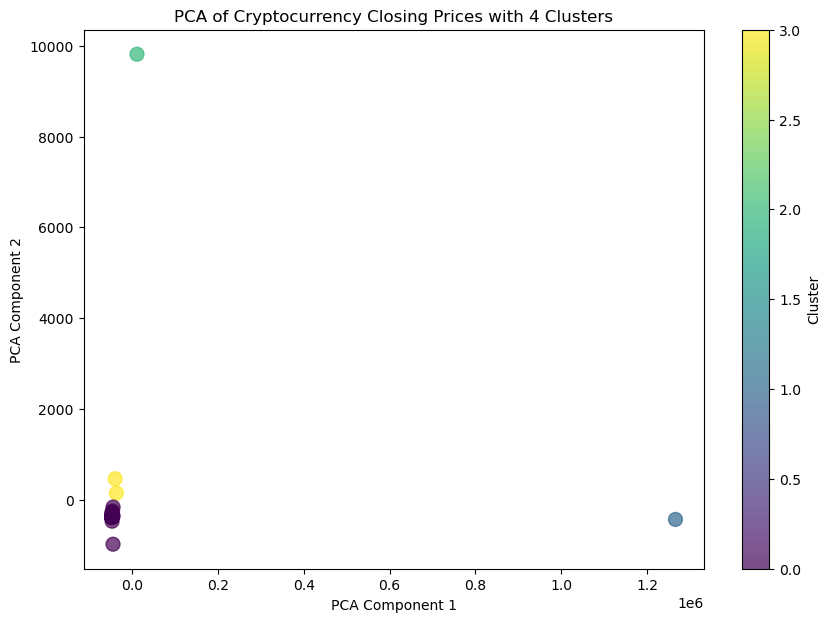

PCA and clustering results saved to: cryptocurrency_pca_clusters.csv


In [47]:
file_path = 'transformed_cryptocurrency_data_with_dates.csv'
data = pd.read_csv(file_path, index_col=0)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Perform KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Create a DataFrame with PCA results and clusters for easier analysis
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'], index=data.index)
pca_df['Cluster'] = clusters

# Save the PCA and cluster results to a new CSV file
output_file_path = 'cryptocurrency_pca_clusters.csv'
pca_df.to_csv(output_file_path)

# Visualizing the results in a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Cryptocurrency Closing Prices with 4 Clusters')
plt.show()

# Print confirmation of saved file
print(f"PCA and clustering results saved to: {output_file_path}")

In [63]:
file_path = 'cryptocurrency_pca_clusters.csv'
pca_df = pd.read_csv(file_path)
pca_df['Cryptocurrency'] = pca_df.iloc[:, 0]

# Find the centroids of the clusters
centroids = kmeans.cluster_centers_

# Add the centroid distance to the DataFrame
pca_df['Centroid Distance'] = np.linalg.norm(pca_df[['PCA1', 'PCA2']].values - centroids[pca_df['Cluster']], axis=1)

# Select one cryptocurrency per cluster (the one closest to the cluster centroid)
selected_cryptos = pca_df.loc[pca_df.groupby('Cluster')['Centroid Distance'].idxmin()]

# Display the selected cryptocurrencies for each cluster
print(selected_cryptos[['Cryptocurrency', 'Cluster', 'PCA1', 'PCA2']])

   Cryptocurrency  Cluster          PCA1         PCA2
9        DASH-USD        0 -4.619592e+04  -329.235065
7         BTC-USD        1  1.265677e+06  -437.363798
14        ETH-USD        2  1.179389e+04  9815.835735
6         BNB-USD        3 -3.611649e+04   142.431163


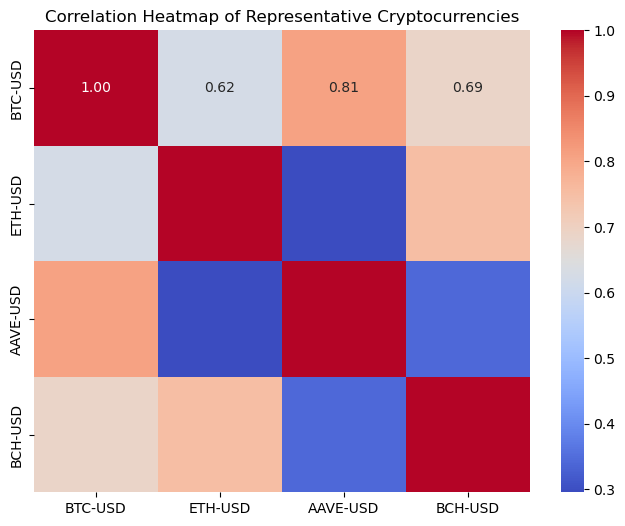

Top 4 Highly Correlated Pairs:
BTC-USD   AAVE-USD    0.808726
AAVE-USD  BTC-USD     0.808726
ETH-USD   BCH-USD     0.752037
BCH-USD   ETH-USD     0.752037
dtype: float64


In [71]:
# Filter the data to include only the representative cryptocurrencies
representative_cryptos = ["BTC-USD", "ETH-USD", "AAVE-USD", "BCH-USD"]
filtered_data = data.loc[representative_cryptos].T

# Calculate the correlation matrix for the representative cryptocurrencies
correlation_matrix = filtered_data.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Representative Cryptocurrencies")
plt.show()

# Extracting the top 4 highly correlated pairs from the correlation matrix
# Flatten the matrix and filter out self-correlations (diagonal values)
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs < 1]  # Exclude self-correlation (1)
top_4_highly_correlated = correlation_pairs.sort_values(ascending=False).head(4)

# Display the top 4 highly correlated pairs
print("Top 4 Highly Correlated Pairs:")
print(top_4_highly_correlated)

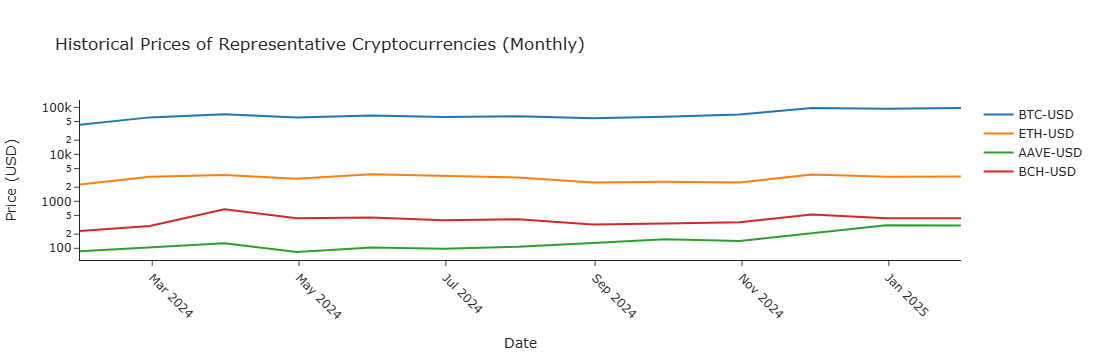

In [107]:
import plotly.graph_objects as go
# Load data and resample to monthly frequency
data_with_dates = pd.read_csv('transformed_cryptocurrency_data_with_dates.csv')
data_with_dates = data_with_dates.set_index("Unnamed: 0").T
data_with_dates.index = pd.to_datetime(data_with_dates.index)
data_with_dates = data_with_dates.resample('M').last()

# Define the list of representative cryptocurrencies
fig = go.Figure()
# Add a trace for each cryptocurrency
for crypto in representative_cryptos:
    # Extract the data for each cryptocurrency 
    crypto_data = data_with_dates[crypto]
    # Add trace for each cryptocurrency
    fig.add_trace(go.Scatter(x=crypto_data.index, 
                             y=crypto_data.values, 
                             mode='lines', 
                             name=crypto,
                             hovertemplate='Date: %{x}<br>Price: %{y}<br><extra></extra>'))

# Customize the layout
fig.update_layout(
    title="Historical Prices of Representative Cryptocurrencies (Monthly)",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    xaxis_tickangle=45,
    template='simple_white',
    yaxis_type='log'
)

# Show the figure
fig.show()

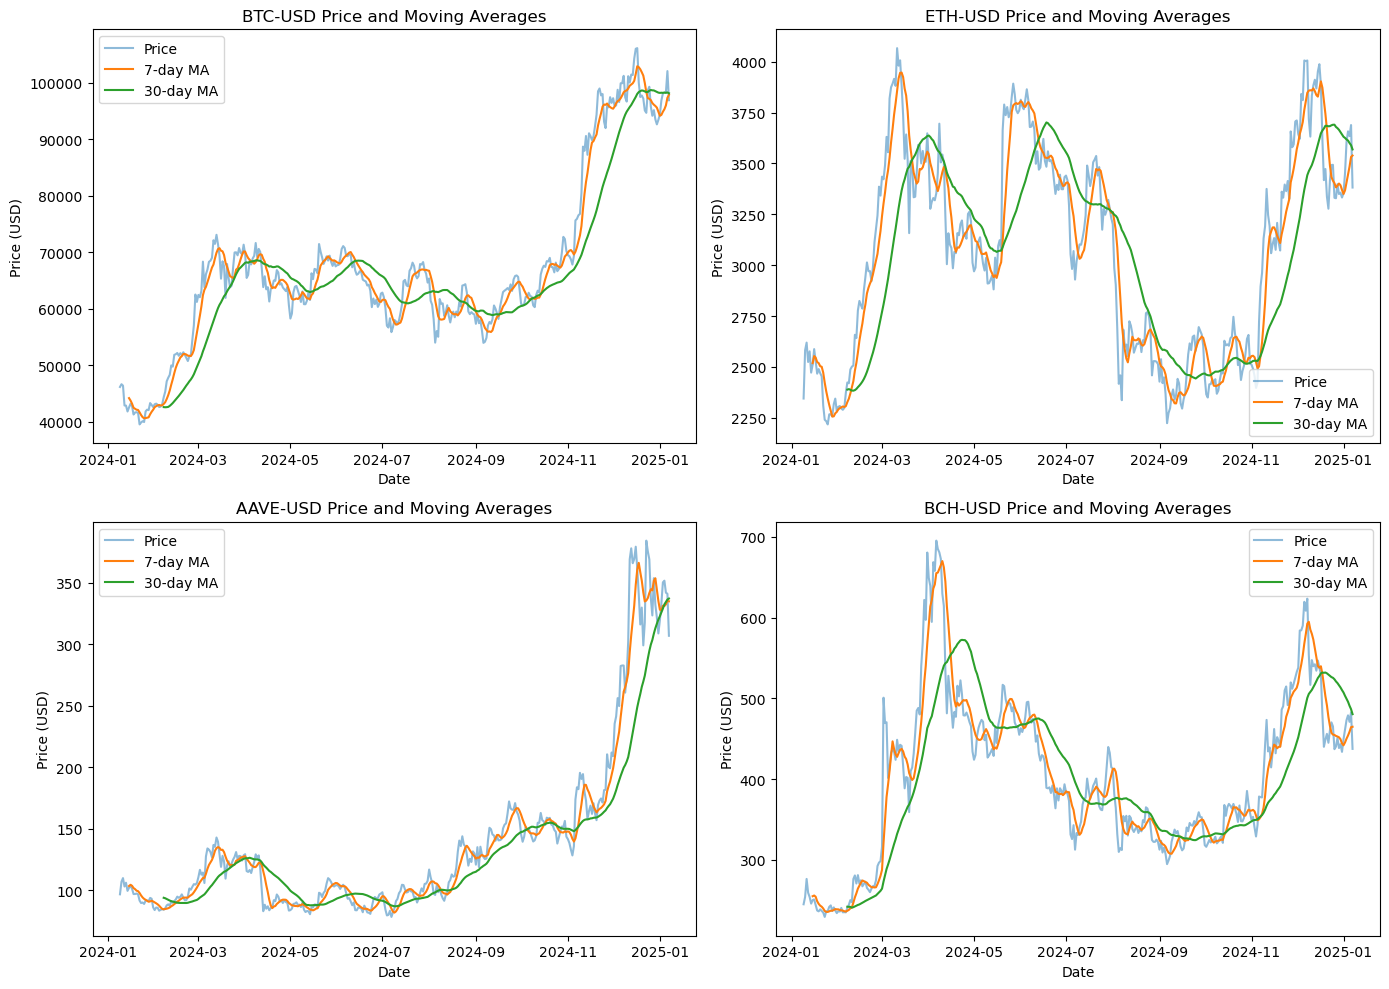

In [119]:
crypto_data = data_with_dates_transposed[representative_cryptos]
# Calculate 7-day and 30-day moving averages
moving_averages = {}
for symbol in representative_cryptos:
    moving_averages[symbol] = {
        "7-day": crypto_data[symbol].rolling(window=7).mean(),
        "30-day": crypto_data[symbol].rolling(window=30).mean()
    }
# Plot the moving averages for each cryptocurrency
plt.figure(figsize=(14, 10))

for i, symbol in enumerate(representative_cryptos, 1):
    plt.subplot(2, 2, i)
    plt.plot(crypto_data[symbol], label="Price", alpha=0.5)
    plt.plot(moving_averages[symbol]["7-day"], label="7-day MA")
    plt.plot(moving_averages[symbol]["30-day"], label="30-day MA")
    plt.title(f"{symbol} Price and Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()

plt.tight_layout()
plt.show()


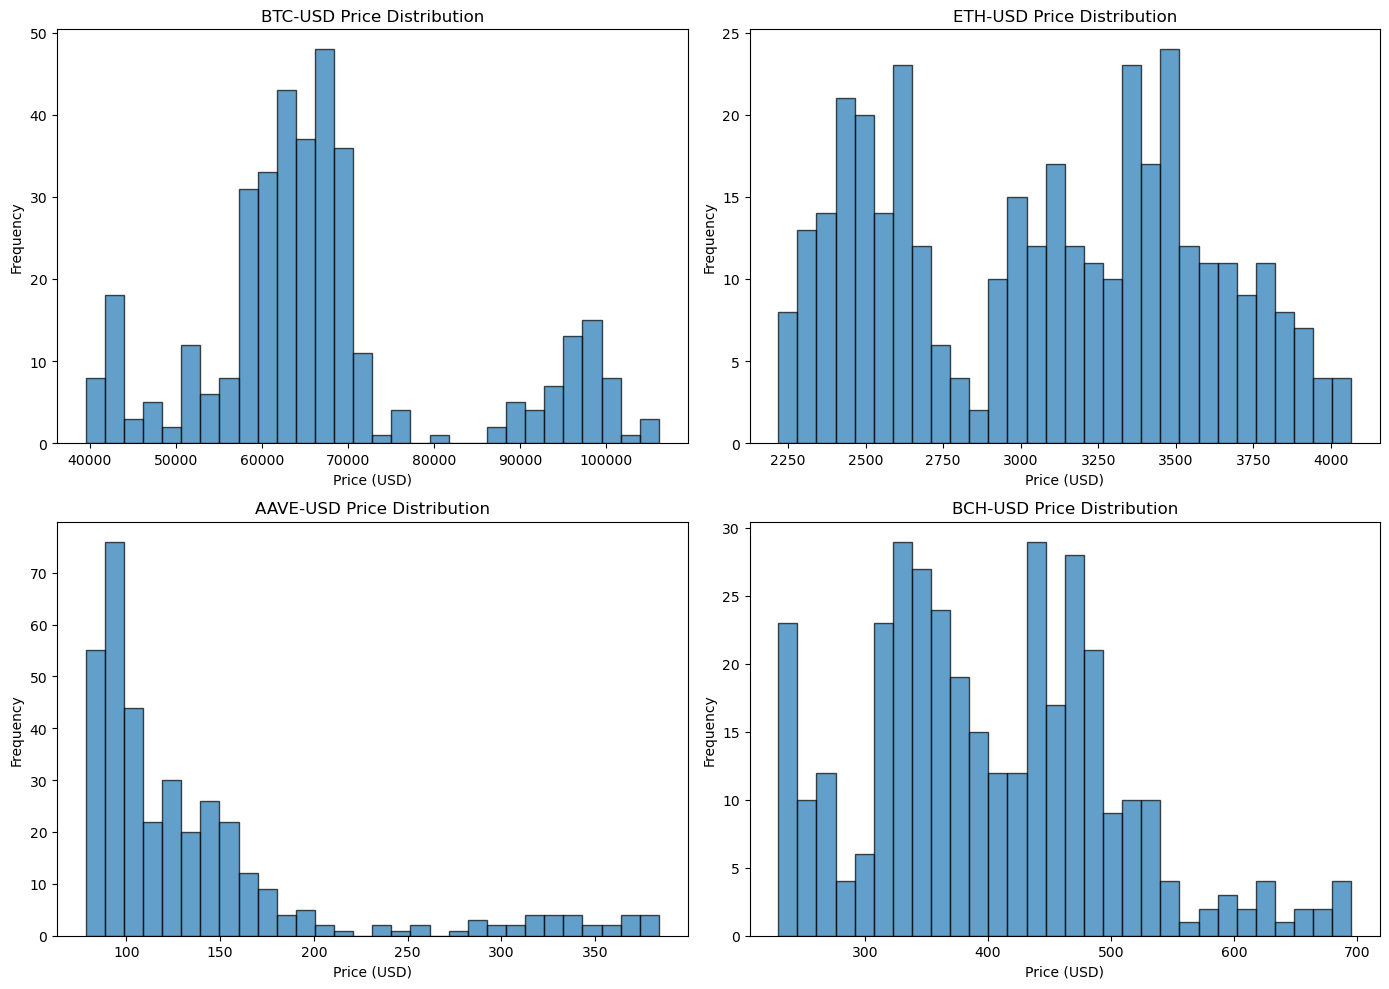

In [121]:
# Plot price distributions (histograms) for each cryptocurrency
plt.figure(figsize=(14, 10))

for i, symbol in enumerate(representative_cryptos, 1):
    plt.subplot(2, 2, i)
    plt.hist(crypto_data[symbol].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"{symbol} Price Distribution")
    plt.xlabel("Price (USD)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [135]:
for crypto in representative_cryptos:
    crypto_data = data_with_dates[crypto].dropna()

    # Print the first few values to check if the data is correct
    print(f"\nData for {crypto}:")
    print(crypto_data.head())

    # Perform the ADF test
    adf_result = adfuller(crypto_data)

    # Print the results of ADF test
    print(f"ADF Test for {crypto}:")
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("-----------------------------------------")



Data for BTC-USD:
2024-01-09    46139.730469
2024-01-10    46627.777344
2024-01-11    46368.585938
2024-01-12    42853.167969
2024-01-13    42842.382812
Name: BTC-USD, dtype: float64
ADF Test for BTC-USD:
ADF Statistic: -0.777537516118663
p-value: 0.8256313764540525
-----------------------------------------

Data for ETH-USD:
2024-01-09    2344.827148
2024-01-10    2582.103516
2024-01-11    2619.619141
2024-01-12    2524.460205
2024-01-13    2576.597900
Name: ETH-USD, dtype: float64
ADF Test for ETH-USD:
ADF Statistic: -2.220989348921105
p-value: 0.19871591470418748
-----------------------------------------

Data for AAVE-USD:
2024-01-09     96.592918
2024-01-10    106.842682
2024-01-11    109.765533
2024-01-12    102.936180
2024-01-13    105.992989
Name: AAVE-USD, dtype: float64
ADF Test for AAVE-USD:
ADF Statistic: -0.10570199871700099
p-value: 0.9488676223985619
-----------------------------------------

Data for BCH-USD:
2024-01-09    245.189453
2024-01-10    254.239105
2024-01-11

In [141]:
# Apply differencing if p-value > 0.05
if adf_result[1] > 0.05:
    print(f"{crypto} is non-stationary. Applying differencing...")
    crypto_data_diff = crypto_data.diff().dropna()
else:
    print(f"{crypto} is stationary. No differencing applied.")
    crypto_data_diff = crypto_data

# Print the first few rows of the differenced data
print(f"Differenced Data for {crypto}:")
print(crypto_data_diff.head())
print("-----------------------------------------")

BCH-USD is non-stationary. Applying differencing...
Differenced Data for BCH-USD:
2024-01-10     9.049652
2024-01-11    22.289001
2024-01-12   -17.072601
2024-01-13    -5.232285
2024-01-14    -8.217438
Name: BCH-USD, dtype: float64
-----------------------------------------


In [155]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import streamlit as st

In [179]:
data_with_dates_transposed.shape

(365, 30)

In [12]:
# Fit ARIMA model with initial parameters (adjust if necessary)
model = ARIMA(btc_data_diff, order=(2, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                  364
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3254.623
Date:                Wed, 08 Jan 2025   AIC                           6517.246
Time:                        11:31:06   BIC                           6532.824
Sample:                    01-10-2024   HQIC                          6523.438
                         - 01-07-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0543      0.046     -1.190      0.234      -0.144       0.035
ar.L2          0.0377      0.053      0.709      0.478      -0.067       0.142
ma.L1         -1.0000      0.052    -19.100      0.0

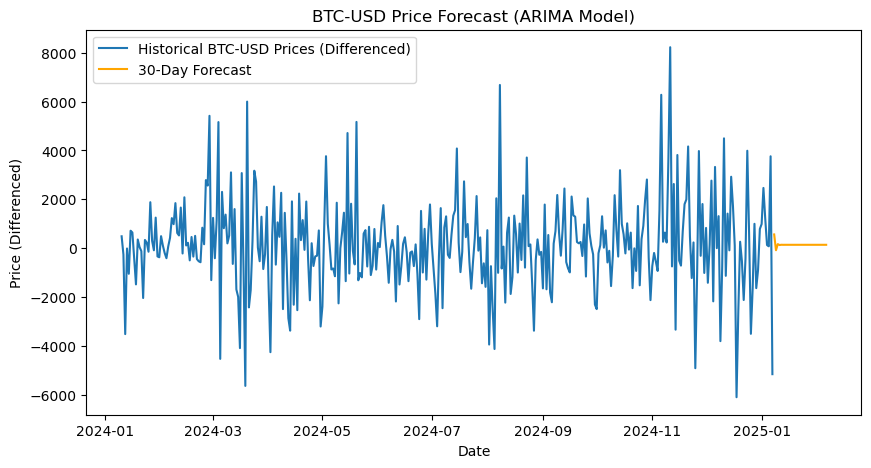

In [13]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot the historical data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(btc_data_diff, label="Historical BTC-USD Prices (Differenced)" if adf_result[1] > 0.05 else "Historical BTC-USD Prices")
plt.plot(pd.date_range(btc_data.index[-1] + pd.Timedelta(days=1), periods=30), forecast, label="30-Day Forecast", color='orange')
plt.title("BTC-USD Price Forecast (ARIMA Model)")
plt.xlabel("Date")
plt.ylabel("Price (Differenced)" if adf_result[1] > 0.05 else "Price (USD)")
plt.legend()
plt.show()


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.9210
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.7759
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.6374
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.5041
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3763
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2563
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1490
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0628
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0098
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0041
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0471
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1002
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1202
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1044
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0710
Epoch 16/50
1/1 ━━━━━━━━

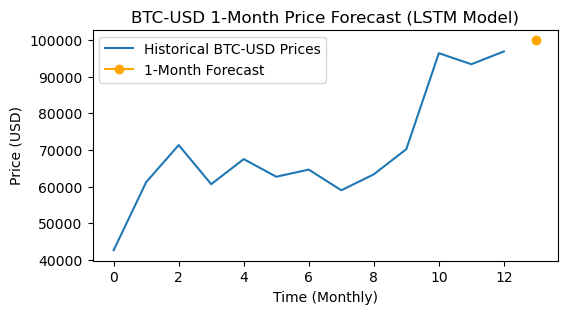

1-Month Forecasted BTC-USD Price: 99992.53


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('transformed_cryptocurrency_data_with_dates.csv')
data = data.set_index("Unnamed: 0").T
data.index = pd.to_datetime(data.index)

# Resample to monthly data using the last day of each month and select BTC-USD
btc_data = data["BTC-USD"].resample('M').last().dropna().values.reshape(-1, 1)

# Scale data to [0, 1] for LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
btc_data_scaled = scaler.fit_transform(btc_data)

# Create sequences for LSTM (use last 12 months to predict the next month)
sequence_length = 12
X, y = [], []
for i in range(len(btc_data_scaled) - sequence_length):
    X.append(btc_data_scaled[i:i + sequence_length])
    y.append(btc_data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=1, epochs=50)

# Prepare the input for forecasting (last 12 months of data)
last_sequence = btc_data_scaled[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

# Predict the next 1 month
next_month_prediction_scaled = model.predict(last_sequence)
next_month_prediction = scaler.inverse_transform(next_month_prediction_scaled)

# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(btc_data, label="Historical BTC-USD Prices")
plt.plot(np.arange(len(btc_data), len(btc_data) + 1), next_month_prediction, marker='o', color='orange', label="1-Month Forecast")
plt.title("BTC-USD 1-Month Price Forecast (LSTM Model)")
plt.xlabel("Time (Monthly)")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Print the forecasted price for the next month
print("1-Month Forecasted BTC-USD Price:", next_month_prediction[0, 0])

In [ ]:
!pip install prophet

C:\Users\Dell\AppData\Local\Temp\ipykernel_12016\240005199.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_with_dates = data_with_dates.resample('M').last()
02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:12:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dell\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 600x300 with 0 Axes>

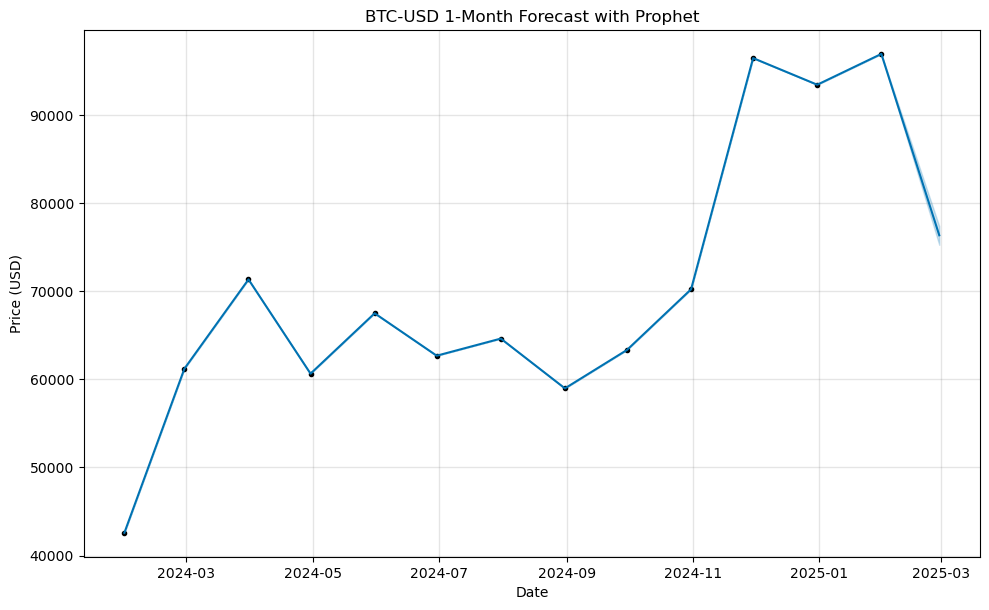

Forecasted Price for BTC-USD in the next month:
                    yhat
ds                      
2025-02-28  76343.364768


02:12:27 - cmdstanpy - INFO - Chain [1] start processing
02:12:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dell\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 600x300 with 0 Axes>

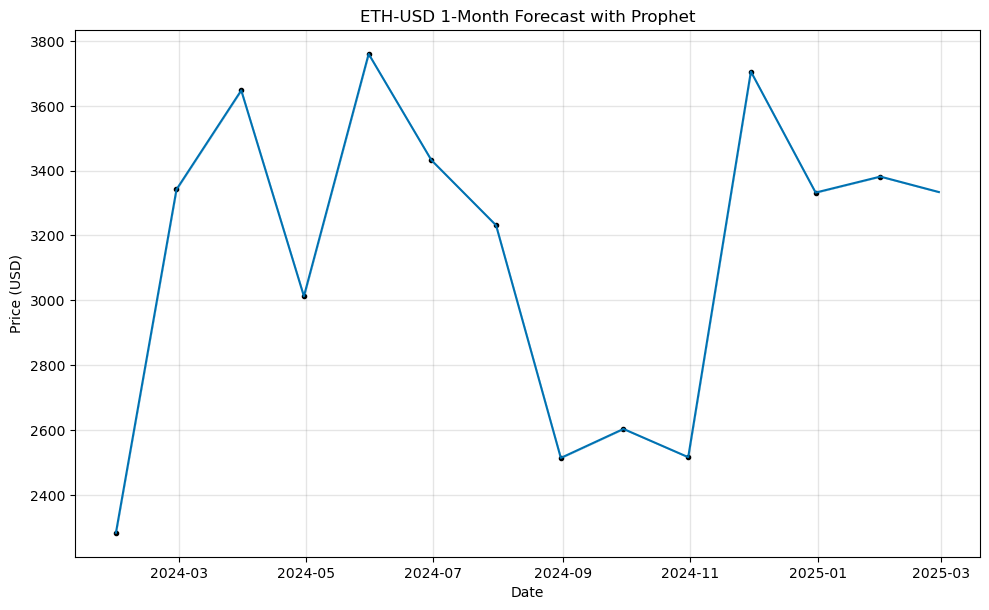

Forecasted Price for ETH-USD in the next month:
                   yhat
ds                     
2025-02-28  3333.993812


02:12:31 - cmdstanpy - INFO - Chain [1] start processing
02:12:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dell\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 600x300 with 0 Axes>

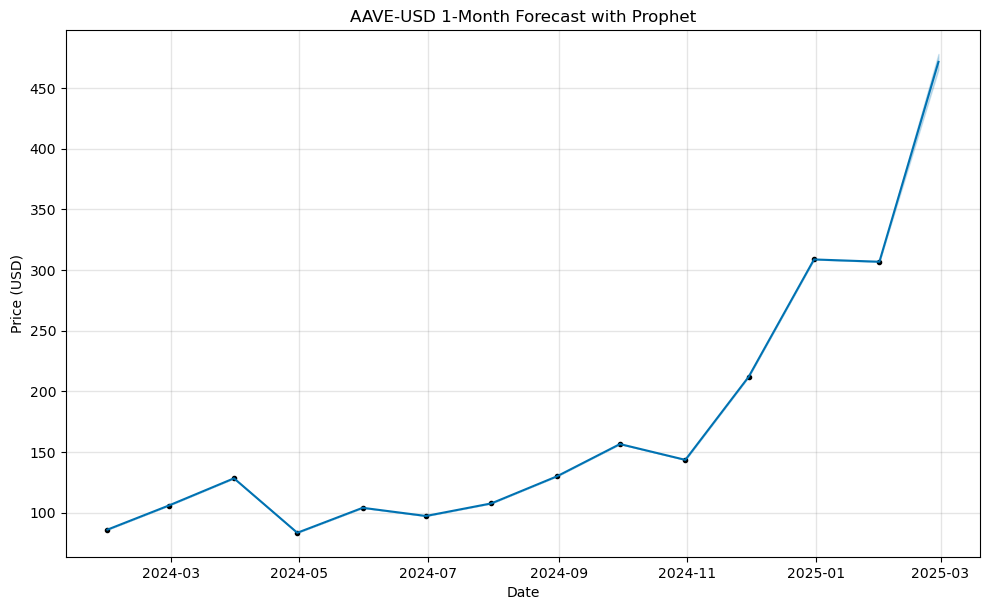

Forecasted Price for AAVE-USD in the next month:
                  yhat
ds                    
2025-02-28  471.468533


02:12:36 - cmdstanpy - INFO - Chain [1] start processing
02:12:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dell\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 600x300 with 0 Axes>

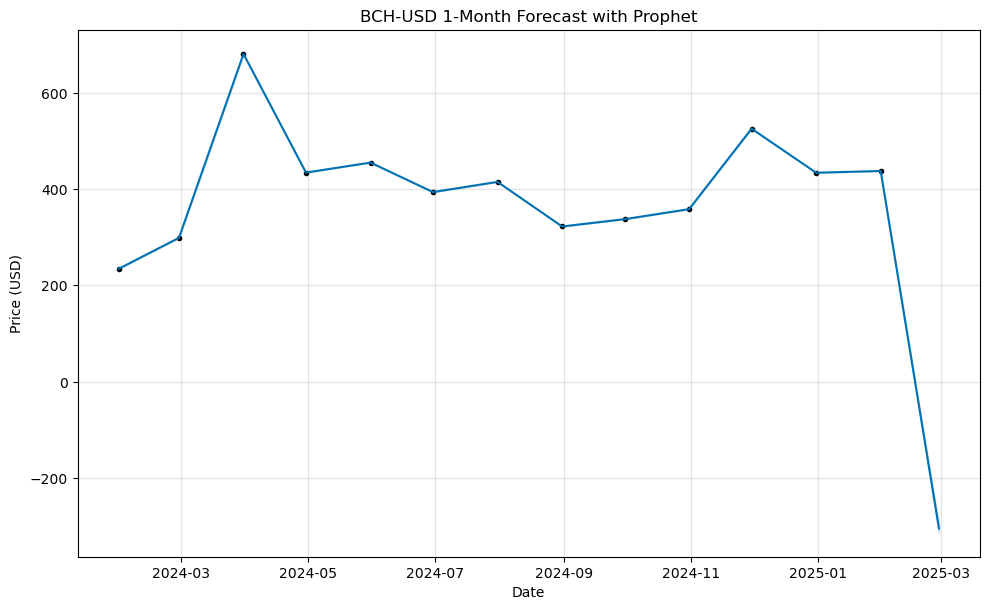

Forecasted Price for BCH-USD in the next month:
                  yhat
ds                    
2025-02-28 -304.932339


In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load data and resample to monthly frequency
data_with_dates = pd.read_csv('transformed_cryptocurrency_data_with_dates.csv')
data_with_dates = data_with_dates.set_index("Unnamed: 0").T
data_with_dates.index = pd.to_datetime(data_with_dates.index)
data_with_dates = data_with_dates.resample('M').last()

# Select the cryptocurrencies and prepare the data for Prophet
crypto_symbols = ["BTC-USD", "ETH-USD", "AAVE-USD", "BCH-USD"]
forecasts = {}

for symbol in crypto_symbols:
    # Prepare data for Prophet
    df = data_with_dates[[symbol]].reset_index()
    df.columns = ["ds", "y"]  # Prophet expects columns 'ds' (date) and 'y' (value)

    # Initialize and fit Prophet model
    model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False)
    model.fit(df)

    # Make a 1-month forecast
    future = model.make_future_dataframe(periods=1, freq='M')
    forecast = model.predict(future)
    forecasts[symbol] = forecast

    # Plot the forecast
    plt.figure(figsize=(6, 3))
    model.plot(forecast)
    plt.title(f"{symbol} 1-Month Forecast with Prophet")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

    # Display the forecasted value for the next month
    forecasted_price = forecast[['ds', 'yhat']].tail(1).set_index('ds')
    print(f"Forecasted Price for {symbol} in the next month:")
    print(forecasted_price)


C:\Users\Dell\AppData\Local\Temp\ipykernel_12016\3447442879.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_with_dates = data_with_dates.resample('M').last()
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


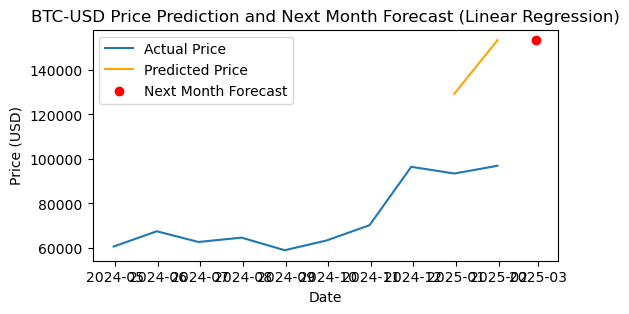

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


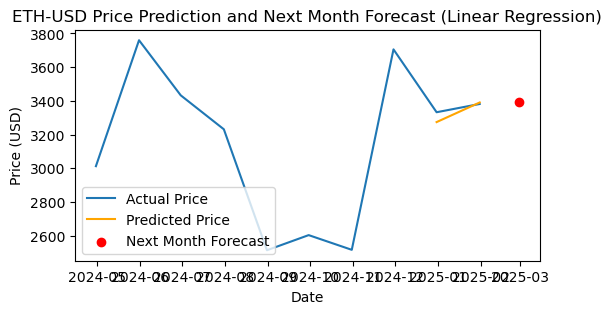

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


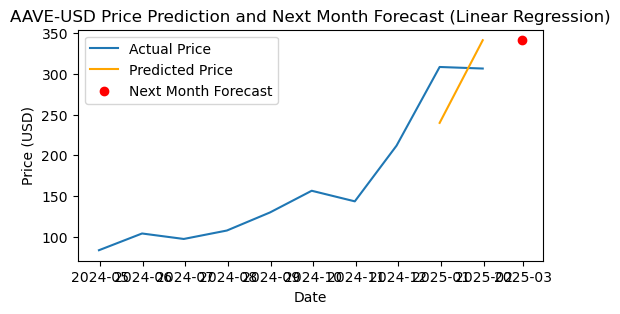

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


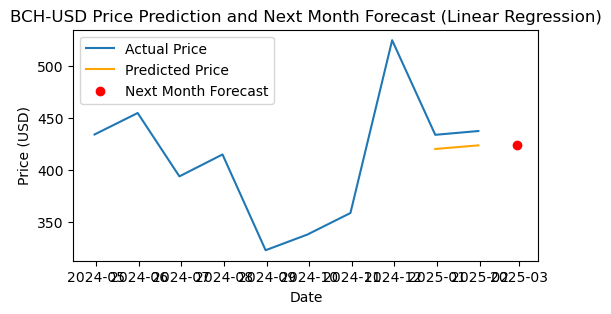

Forecasted Prices for the Next Month:
BTC-USD: 153334.74 USD
ETH-USD: 3390.47 USD
AAVE-USD: 341.54 USD
BCH-USD: 423.61 USD


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data and resample to monthly frequency
data_with_dates = pd.read_csv('transformed_cryptocurrency_data_with_dates.csv')
data_with_dates = data_with_dates.set_index("Unnamed: 0").T
data_with_dates.index = pd.to_datetime(data_with_dates.index)
data_with_dates = data_with_dates.resample('M').last()

# Select the cryptocurrencies
crypto_symbols = ["BTC-USD", "ETH-USD", "AAVE-USD", "BCH-USD"]

# Dictionary to store forecasts
forecasts = {}

for symbol in crypto_symbols:
    # Prepare the data for linear regression
    df = data_with_dates[[symbol]].dropna().reset_index()
    df.columns = ["Date", "Price"]
    
    # Create lagged features (using previous 3 months as features)
    df['Price_Lag_1'] = df['Price'].shift(1)
    df['Price_Lag_2'] = df['Price'].shift(2)
    df['Price_Lag_3'] = df['Price'].shift(3)
    df = df.dropna()
    
    # Define features and target
    X = df[['Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3']]
    y = df['Price']
    
    # Train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = model.predict(X_test)
    
    # Forecast the next month
    last_values = df[['Price_Lag_1', 'Price_Lag_2', 'Price_Lag_3']].iloc[-1].values.reshape(1, -1)
    next_month_forecast = model.predict(last_values)
    
    # Store the forecasted value
    forecasts[symbol] = next_month_forecast[0]
    
    # Plot the results
    plt.figure(figsize=(6, 3))
    plt.plot(df['Date'], df['Price'], label="Actual Price")
    plt.plot(df['Date'].iloc[len(X_train):], y_pred, label="Predicted Price", color="orange")
    plt.scatter(df['Date'].iloc[-1] + pd.DateOffset(months=1), next_month_forecast, color="red", label="Next Month Forecast")
    plt.title(f"{symbol} Price Prediction and Next Month Forecast (Linear Regression)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

# Display forecasted prices for the next month
print("Forecasted Prices for the Next Month:")
for symbol, forecast in forecasts.items():
    print(f"{symbol}: {forecast:.2f} USD")
